In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from dimension_reduction import DimensionReduction

from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

import seaborn as sns
from collections import Counter
from sklearn.model_selection import GridSearchCV

from kneed import KneeLocator
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import log_loss

import warnings
warnings.filterwarnings("ignore")

## Loading the dataset

In [2]:
df = pd.read_csv('data.csv')
df.head()

0           1           2          3          4          5          6  \
0  D_0 -166.792114   48.673981 -61.681690  23.588770 -24.922943 -22.071186   
1  D_0 -196.336411  137.743591 -30.724380  35.839794 -24.167620   8.170997   
2  D_0 -255.626404   97.742905 -91.593735   4.170034 -29.750544 -26.448723   
3  D_0 -202.974701   79.678085 -83.443153   2.970738 -63.702785  -8.550585   
4  D_0  -60.888184   99.207787  12.871638   7.476836  -8.987703  18.245726   

           7          8          9  ...        60        61        62  \
0 -25.099222 -14.969215 -22.405672  ...  0.198428  0.025338  0.153881   
1  -8.422764   6.116524  -9.430403  ...  0.102050  0.077792  0.051169   
2 -19.965393 -17.997416  -1.946816  ...  0.034188  0.136815  0.013002   
3 -37.902176  -5.894975 -21.274141  ...  0.056353  0.096599  0.016630   
4  -8.740259  11.888105 -19.923634  ...  0.092568  0.035146  0.132840   

         63        64        65        66        67           68  \
0  0.046216  0.057083  0.014590  0.019117  0.136555  2436.000953   
1  0.093380  0.070790  0.105666  0.014385  0.117292  1553.866767   
2  0.124663  0.078147  0.080960  0.074701  0.022163  1788.712108   
3  0.158240  0.062040  0.088392  0.071505  0.081503  2253.616971   
4  0.031000  0.072270  0.025156  0.016877  0.041455  2222.938917   

              69  
0  229407.109103  
1  127935.952433  
2   83405.215831  
3  210885.140703  
4  174010.699956  

[5 rows x 70 columns]

In [3]:
X = df.drop(["0"], axis=1)
y = df["0"]

# Preprocess
#### Label Encoding

In [4]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

#### Train Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=31)

Text(0.5, 1.0, 'Dastgah Frequency of Train')

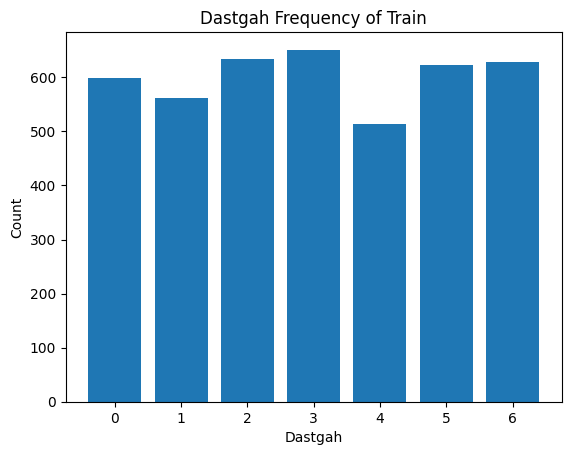

In [6]:
plt.bar(list(Counter(y_train).keys()), list(Counter(y_train).values()))
plt.xlabel('Dastgah')
plt.ylabel('Count')
plt.title('Dastgah Frequency of Train')

Text(0.5, 1.0, 'Dastgah Frequency of Test')

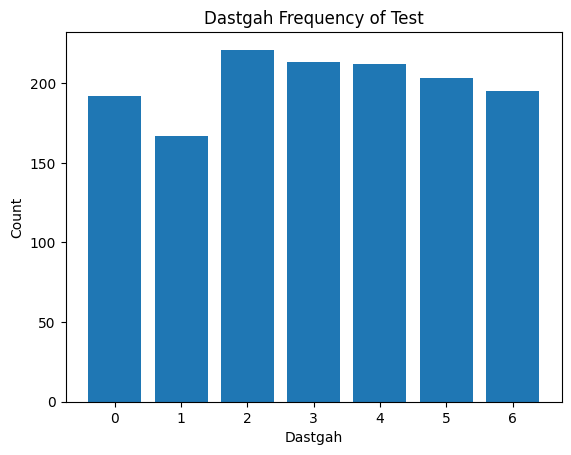

In [7]:
plt.bar(list(Counter(y_test).keys()), list(Counter(y_test).values()))
plt.xlabel('Dastgah')
plt.ylabel('Count')
plt.title('Dastgah Frequency of Test')

#### Normalization

In [9]:
scaler = StandardScaler()
X_test = scaler.fit_transform(np.array(X_test, dtype = float))
X_train = scaler.transform(np.array(X_train, dtype = float))

# Classification

In [10]:
def evaluate(model):
    print("--------------------------------Train-------------------------------\n")
    print(classification_report(y_train, model.predict(X_train)))
    print("Error:", log_loss(y_train, model.predict_proba(X_train)))
    print("\n")
    print("--------------------------------Test--------------------------------\n")
    print(classification_report(y_test, model.predict(X_test)))
    print("Error:", log_loss(y_test, model.predict_proba(X_test)))

In [11]:
def plot_roc_curve(model, X, y, n_classes, title):
    y = label_binarize(y, classes = np.arange(n_classes))
    y_pred = label_binarize(model.predict(X), classes = np.arange(n_classes))

    for i in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        label = 'ROC of class {0} (area={1:0.2f})'.format(i, roc_auc)
        plt.plot(fpr, tpr, label = label)
        plt.plot([0, 1], [0, 1], linestyle = '--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve of ' + title)
        plt.legend(loc = 'lower right')

    plt.show()

In [12]:
def display_model_history(history):
  plt.figure(figsize=(10, 5)) 
  plt.plot(history.history['accuracy'], label = 'Train')
  plt.plot(history.history['val_accuracy'], label = 'Validation')
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.figure(figsize=(10, 5)) 
  plt.plot(history.history['loss'], label = 'Train')
  plt.plot(history.history['val_loss'], label = 'Validation')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

#### Support Vector Machine(SVM)

In [12]:
c = [1e-1, 1e0, 1e1]
gammas = [1e-1, 1e0, 1e1]
model = SVC(kernel = 'rbf', decision_function_shape = 'ovr')
params = dict(C = c, gamma = gammas)
svc = GridSearchCV(model, params, cv = 10)
svc.fit(X_train, y_train)
print('Best parameters for SVM:', svc.best_params_)

Best parameters for SVM: {'C': 10.0, 'gamma': 0.1}


#### Applying the best parameters

In [13]:
best_svc = SVC(
    kernel = 'rbf', 
    decision_function_shape = 'ovr', 
    C=svc.best_params_['C'], 
    gamma=svc.best_params_['gamma'],
    probability=True
)
best_svc.fit(X_train, y_train)
evaluate(best_svc)

--------------------------------Train-------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       598
           1       1.00      1.00      1.00       562
           2       1.00      1.00      1.00       633
           3       1.00      1.00      1.00       651
           4       1.00      0.99      1.00       513
           5       0.99      1.00      0.99       623
           6       1.00      1.00      1.00       629

    accuracy                           1.00      4209
   macro avg       1.00      1.00      1.00      4209
weighted avg       1.00      1.00      1.00      4209

Error: 0.01112527816897476


--------------------------------Test--------------------------------

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       192
           1       0.98      0.80      0.88       167
           2       0.92      0.85      0.88       221
           3     

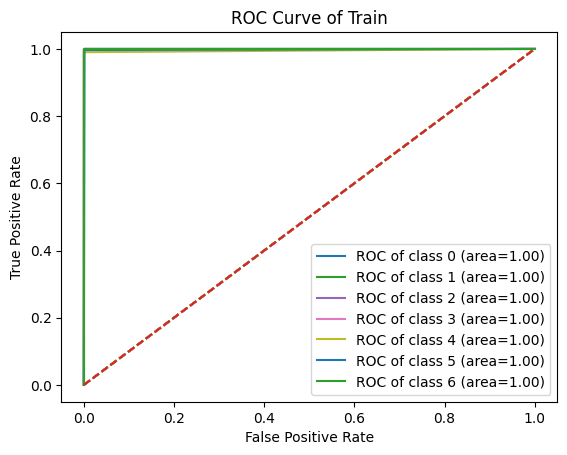

In [14]:
plot_roc_curve(svc, X_train, y_train, n_classes=7, title="Train")

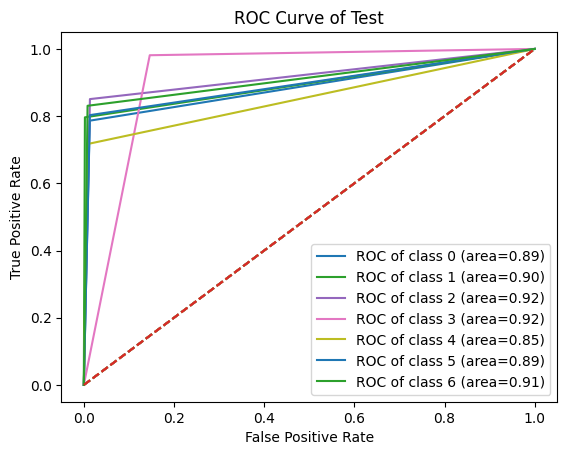

In [15]:
plot_roc_curve(svc, X_test, y_test, n_classes = 7, title="Test")

#### K-Nearest Neighbors(KNN)

In [16]:
k_range = np.arange(2, 20)
params = dict(n_neighbors=k_range)
model = KNeighborsClassifier(weights='distance', metric='manhattan')
KNN = GridSearchCV(model, params, cv = 10)
KNN.fit(X_train, y_train)
print('Best K for KNN:', KNN.best_params_)

Best K for KNN: {'n_neighbors': 2}


#### Applying the best parameters

In [17]:
best_KNN = KNeighborsClassifier(
    n_neighbors=KNN.best_params_["n_neighbors"],
    weights='distance', 
    metric='manhattan'
)
best_KNN.fit(X_train, y_train)
evaluate(best_KNN)

--------------------------------Train-------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       598
           1       1.00      1.00      1.00       562
           2       1.00      1.00      1.00       633
           3       1.00      1.00      1.00       651
           4       1.00      1.00      1.00       513
           5       1.00      1.00      1.00       623
           6       1.00      1.00      1.00       629

    accuracy                           1.00      4209
   macro avg       1.00      1.00      1.00      4209
weighted avg       1.00      1.00      1.00      4209

Error: 0.0003293643053279871


--------------------------------Test--------------------------------

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       192
           1       0.95      0.94      0.94       167
           2       0.90      0.89      0.90       221
           3   

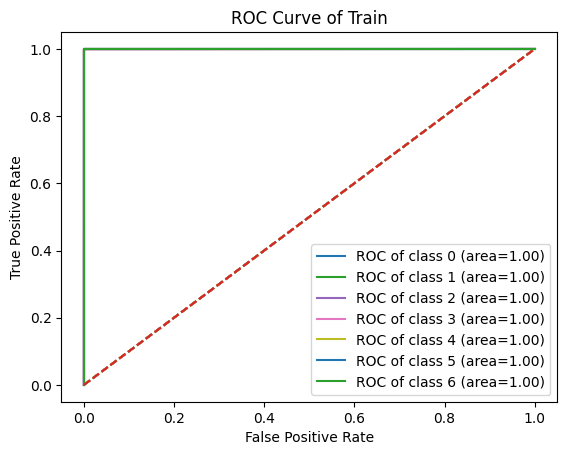

In [18]:
plot_roc_curve(KNN, X_train, y_train, n_classes = 7, title="Train")

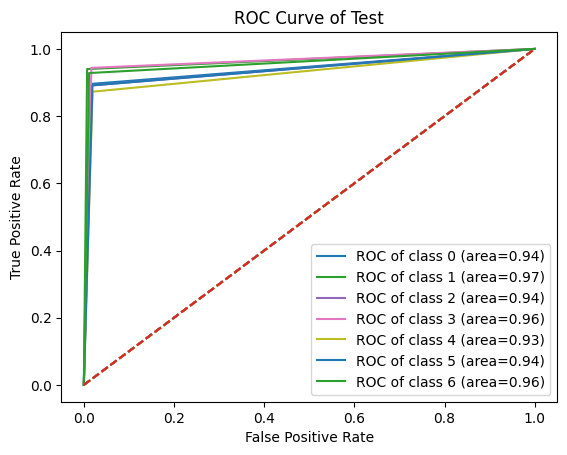

In [19]:
plot_roc_curve(KNN, X_test, y_test, n_classes = 7, title="Test")

#### XGBoost

In [20]:
xgb = XGBClassifier(n_estimators=300)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [21]:
evaluate(xgb)

--------------------------------Train-------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       598
           1       1.00      1.00      1.00       562
           2       1.00      1.00      1.00       633
           3       1.00      1.00      1.00       651
           4       1.00      1.00      1.00       513
           5       1.00      1.00      1.00       623
           6       1.00      1.00      1.00       629

    accuracy                           1.00      4209
   macro avg       1.00      1.00      1.00      4209
weighted avg       1.00      1.00      1.00      4209

Error: 0.003044220030015573


--------------------------------Test--------------------------------

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       192
           1       0.88      0.84      0.86       167
           2       0.78      0.84      0.81       221
           3    

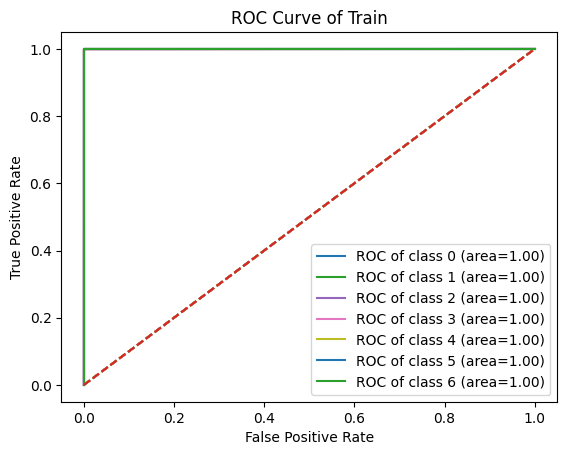

In [22]:
plot_roc_curve(xgb, X_train, y_train, n_classes = 7, title="Train")

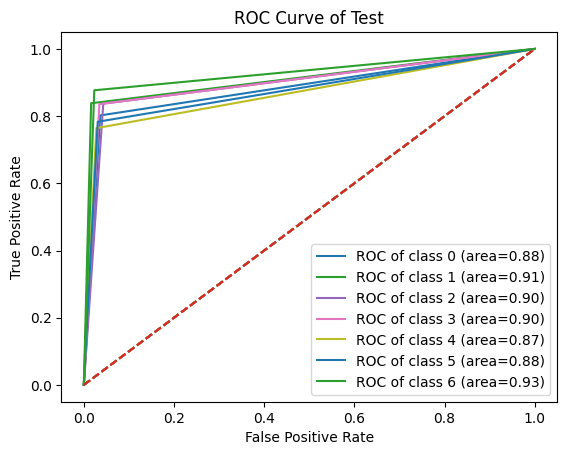

In [23]:
plot_roc_curve(xgb, X_test, y_test, n_classes = 7, title="Test")

#### MLP

In [17]:
model = MLPClassifier(hidden_layer_sizes = (128, 64, 32, 8), solver = 'sgd',learning_rate_init = 0.006)
params = {
    'momentum': np.arange(0.4,1.1,0.15),
   'max_iter': np.arange(100,500,100),
    'batch_size':[8,16,32]
}
mlp = GridSearchCV(model, params, n_jobs=5, cv=10)
mlp.fit(X_train, y_train) 
print("Best params for MLP :(best parameters) ",mlp.best_params_)


Best params for MLP :(best parameters)  {'batch_size': 16, 'max_iter': 400, 'momentum': 0.85}


#### Applying the best parameters

In [24]:
best_MLP = MLPClassifier(hidden_layer_sizes = (128, 64, 32, 8), batch_size = 16, solver = 'sgd', random_state=4,
                    verbose=False, momentum=0.85, max_iter=400, learning_rate_init = 0.006)
best_MLP.fit(X_train, y_train)

MLPClassifier(batch_size=16, hidden_layer_sizes=(128, 64, 32, 8),
              learning_rate_init=0.006, max_iter=400, momentum=0.85,
              random_state=4, solver='sgd')

In [25]:
evaluate(best_MLP)

--------------------------------Train-------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       598
           1       1.00      1.00      1.00       562
           2       1.00      1.00      1.00       633
           3       1.00      1.00      1.00       651
           4       1.00      0.99      1.00       513
           5       0.99      1.00      0.99       623
           6       1.00      1.00      1.00       629

    accuracy                           1.00      4209
   macro avg       1.00      1.00      1.00      4209
weighted avg       1.00      1.00      1.00      4209

Error: 0.0037513933686825793


--------------------------------Test--------------------------------

              precision    recall  f1-score   support

           0       0.75      0.83      0.79       192
           1       0.85      0.80      0.82       167
           2       0.80      0.83      0.82       221
           3   

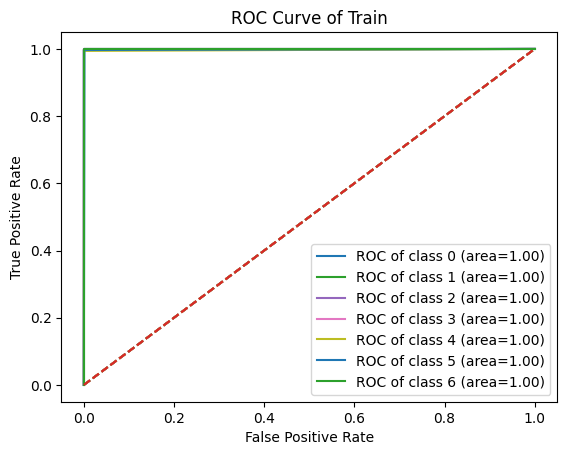

In [26]:
plot_roc_curve(MLP, X_train, y_train, n_classes = 7, title="Train")

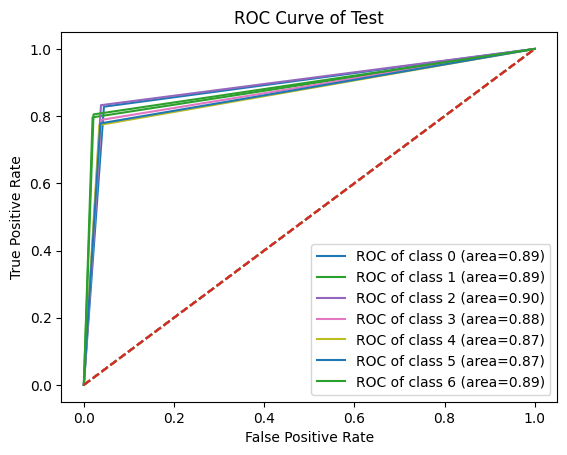

In [27]:
plot_roc_curve(MLP, X_test, y_test, n_classes = 7, title="Test")

#### Logistic Regression

In [20]:
model = LogisticRegression()
params = [{'penalty':['l1','l2'], 'C':np.logspace(-4, 4, 12)}]
lr = GridSearchCV(model, params, cv = 10)
lr.fit(X_train, y_train)
print("Best parameters for Logistic Regression:(best parameters) ",lr.best_params_)

Best parameters for Logistic Regression:(best parameters)  {'C': 0.43287612810830617, 'penalty': 'l1'}


#### Applying the best parameters

In [21]:
best_lr = LogisticRegression( C=lr.best_params_['C'], penalty=lr.best_params_['penalty'])
best_lr.fit(X_train, y_train)
evaluate(best_lr)

--------------------------------Train-------------------------------

             precision    recall  f1-score   support

          0       0.40      0.36      0.38       598
          1       0.52      0.59      0.55       562
          2       0.42      0.43      0.43       633
          3       0.44      0.47      0.46       651
          4       0.49      0.33      0.40       513
          5       0.49      0.50      0.49       623
          6       0.49      0.53      0.51       629

avg / total       0.46      0.46      0.46      4209

Error: 1.5274489171338597


--------------------------------Test--------------------------------

             precision    recall  f1-score   support

          0       0.34      0.31      0.32       192
          1       0.43      0.51      0.47       167
          2       0.43      0.42      0.42       221
          3       0.39      0.42      0.41       213
          4       0.54      0.34      0.42       212
          5       0.42      0.43 

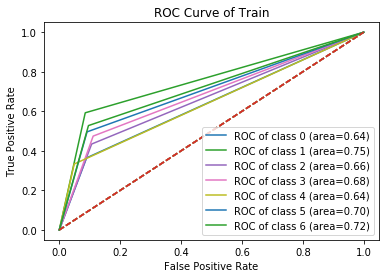

In [22]:
plot_roc_curve(best_lr, X_train, y_train, n_classes = 7, title="Train")

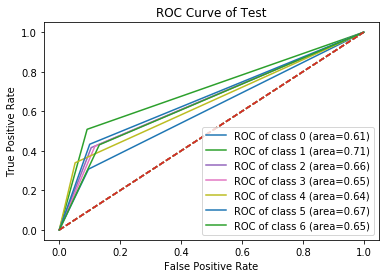

In [23]:
plot_roc_curve(best_lr, X_test, y_test, n_classes = 7, title="Test")

#### LSTM

In [28]:
X_train_new, X_valid, y_train_new, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=31)
y_train_one_hot = to_categorical(y_train_new)
y_valid_one_hot = to_categorical(y_valid)

model = Sequential()
model.add(LSTM(units=128, dropout=0.1, recurrent_dropout=0.35, return_sequences=True, input_shape=(X_train_new.shape[1], 1)))
model.add(LSTM(units=64,  dropout=0.1, recurrent_dropout=0.35, return_sequences=False))
model.add(Dense(units=y_train_one_hot.shape[1], activation="softmax"))

print("Compiling ...")
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

print("Training ...")
history = model.fit(X_train_new, y_train_one_hot, batch_size=64, epochs=80, validation_data = (X_valid, y_valid_one_hot))

2023-02-09 18:09:49.818529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Compiling ...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 69, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 7)                 455       
                                                                 
Total params: 116,423
Trainable params: 116,423
Non-trainable params: 0
_________________________________________________________________
Training ...
Epoch 1/80
60/60 [==============================] - 13s 138ms/step - loss: 1.9350 - accuracy: 0.1671 - val_loss: 1.9319 - val_accuracy: 0.1900
Epoch 2/80
60/60 [==============================] - 8s 139ms/step - loss: 1.9173 - accuracy: 0.1890 - val_loss: 1.9009 - val_accuracy: 0.2067
Ep

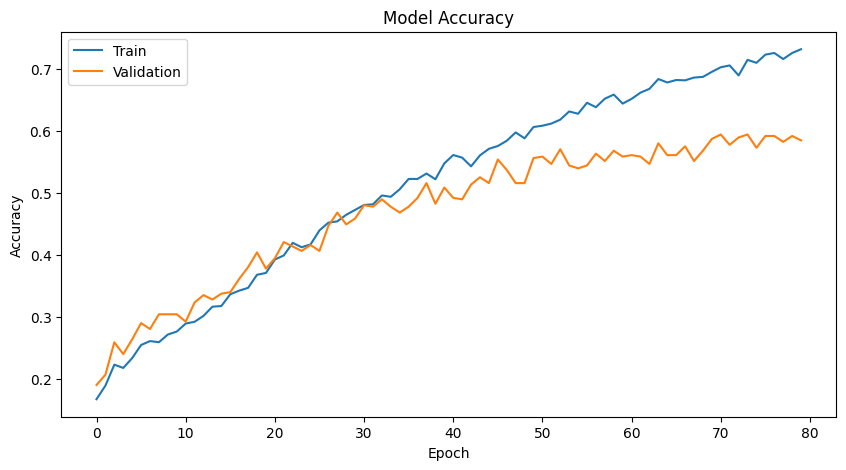

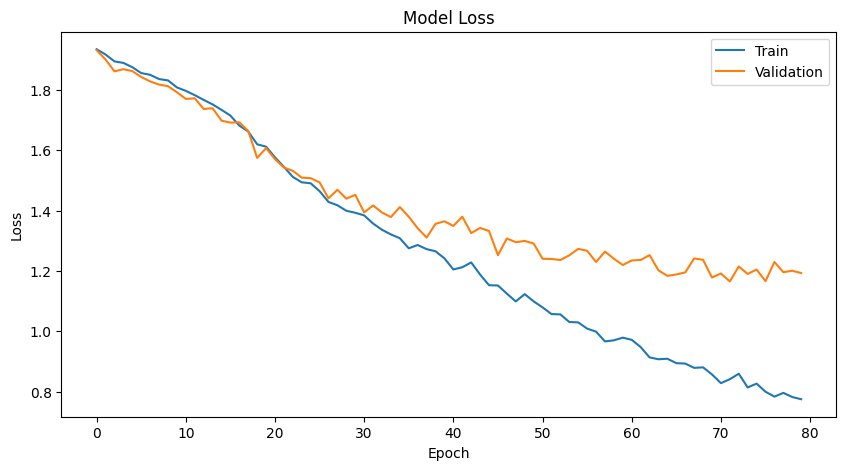

In [29]:
display_model_history(history)

In [39]:
y_pred = np.argmax(model.predict(X_test), axis = 1)
print(classification_report(y_test, y_pred))

44/44 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       192
           1       0.72      0.67      0.69       167
           2       0.59      0.63      0.61       221
           3       0.70      0.66      0.68       213
           4       0.59      0.61      0.60       212
           5       0.59      0.47      0.52       203
           6       0.74      0.79      0.77       195

    accuracy                           0.64      1403
   macro avg       0.65      0.64      0.64      1403
weighted avg       0.64      0.64      0.64      1403



# Feature Selection
#### Linear Discriminant Analysis(LDA)

In [31]:
dr = DimensionReduction(X_train, y_train, X_test, y_test)
X_train_lda, X_test_lda = dr.LDA(n_components=2)

# Clustring 

Determining the ideal number of clusters:

Optimal number of clusters:  6


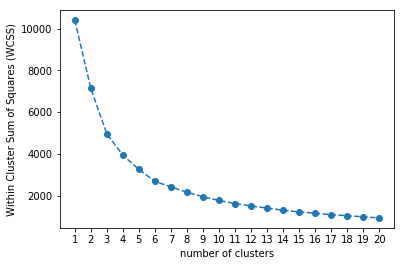

In [9]:
def calculate_erros(data, kmax):
    wse = []
    for k in range(1, kmax+1):
        err = 0
        kmeans = KMeans(n_clusters=k, init='k-means++', algorithm='elkan', max_iter=100).fit(data)
        pred_clusters = kmeans.predict(data)
        for i in range(len(data)):
            center = kmeans.cluster_centers_[pred_clusters[i]]
            err += (data[i, 0] - center[0]) ** 2 + (data[i, 1] -center[1]) ** 2
        wse.append(err)
    return wse

list_of_wss = calculate_erros(X_train_lda, 20)
optimal_k = KneeLocator([i for i in range(1, 21)], list_of_wss, curve='convex', direction='decreasing').knee
print("Optimal number of clusters: ", optimal_k)
plt.plot(range(1, 21), list_of_wss, marker='o',  linestyle='--')
plt.xlabel('number of clusters')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 21))
plt.show()

In [24]:
def plot_dendrogram(train_data,test_data,num_of_features):
    fig, axes = plt.subplots(ncols=2, nrows=1,figsize=(25, 10))
    axes[0].set_title('Dendogram for Train Data with '+ str(num_of_features) +' features')
    clusters = linkage(train_data, method='ward')
    dendrogram(clusters,truncate_mode='lastp',show_contracted=True,ax=axes[0],no_labels=True)
    axes[1].set_title('Dendogram for Test Data with '+ str(num_of_features) +' features')
    clusters = linkage(test_data, method='ward')
    dendrogram(clusters,truncate_mode='lastp',show_contracted=True,ax=axes[1],no_labels=True)
    plt.show()

## Clustring Using Data with 2 Features

In [32]:
def evaluate_clustering(model, number_of_clusters, model_name, d=2):
    if d == 2:
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=model.fit_predict(X_train_lda))
        ax[0].set_title(f"{model_name} Train\nNumber of Clusters: {number_of_clusters}\nSilhouette Score: {round(silhouette_score(X_train_lda, model.fit_predict(X_train_lda)), 5)}")

        ax[1].scatter(X_test_lda[:, 0], X_test_lda[:, 1], c=model.fit_predict(X_test_lda))
        ax[1].set_title(f"{model_name} Test\nNumber of Clusters: {number_of_clusters}\nSilhouette Score: {round(silhouette_score(X_test_lda, model.fit_predict(X_test_lda)), 5)}")
    
    
    if d == 3:
        fig, ax = plt.subplots(1, 2, figsize=(12, 9), subplot_kw=dict(projection='3d'))
        
        ax[0].scatter(X_train_lda[:, 0], X_train_lda[:, 1], X_train_lda[:, 2], c=model.fit_predict(X_train_lda))
        ax[0].set_title(f"{model_name} Train\nNumber of Clusters: {number_of_clusters}\nSilhouette Score: {round(silhouette_score(X_train_lda, model.fit_predict(X_train_lda)), 5)}")

        ax[1].scatter(X_test_lda[:, 0], X_test_lda[:, 1], X_test_lda[:, 2], c=model.fit_predict(X_test_lda))
        ax[1].set_title(f"{model_name} Test\nNumber of Clusters: {number_of_clusters}\nSilhouette Score: {round(silhouette_score(X_test_lda, model.fit_predict(X_test_lda)), 5)}")
    
    
    # print("kMeans train silhouette score: ", silhouette_score(X_train_lda, model.fit_predict(X_train_lda)))
    # print("kMeans test silhouette score: ", silhouette_score(X_test_lda, model.fit_predict(X_test_lda)))

    # if d == 2:
    #     plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=model.fit_predict(X_train_lda))
    # if d == 3:
    #     fig = plt.figure()
    #     ax = fig.add_subplot(111, projection='3d')
    #     ax.scatter(X_train_lda[:, 0], X_train_lda[:, 1], X_train_lda[:, 2], c=model.fit_predict(X_train_lda))
    # plt.show()
    # print("kMeans test silhouette score: ", silhouette_score(X_test_lda, model.fit_predict(X_test_lda)))
    # if d == 2:
    #     plt.scatter(X_test_lda[:, 0], X_test_lda[:, 1], c=model.fit_predict(X_test_lda))
    # if d == 3:
    #     fig = plt.figure()
    #     ax = fig.add_subplot(111, projection='3d')
    #     ax.scatter(X_test_lda[:, 0], X_test_lda[:, 1], X_test_lda[:, 2], c=model.fit_predict(X_test_lda))
    fig.tight_layout()
    plt.show()

## K-Means 

In [33]:
clusters = [2, 7, 20]

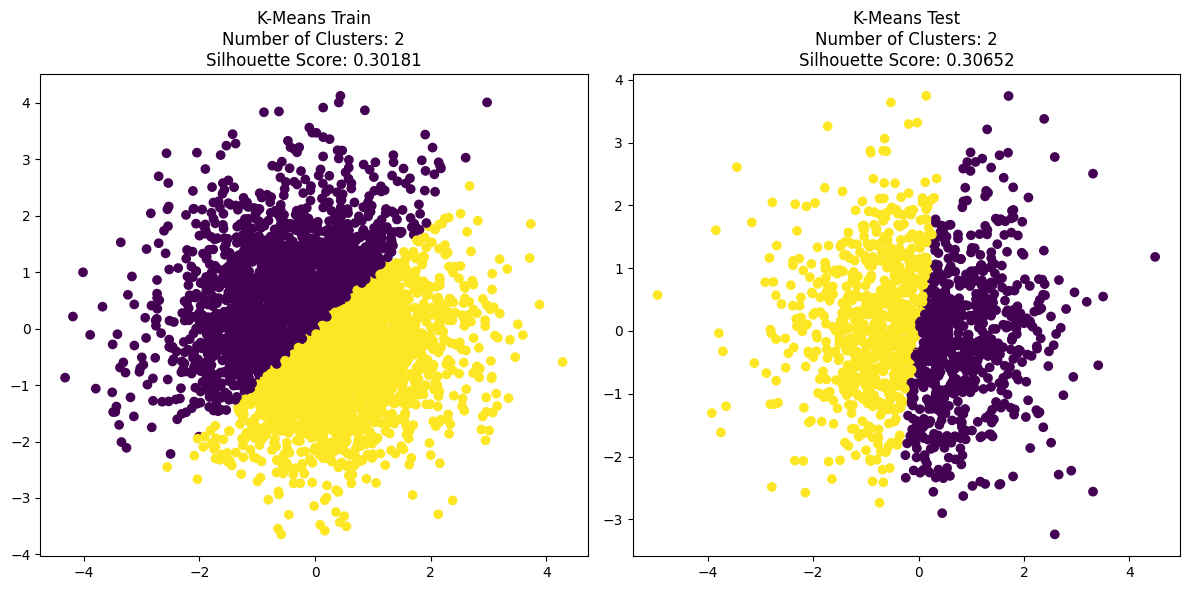

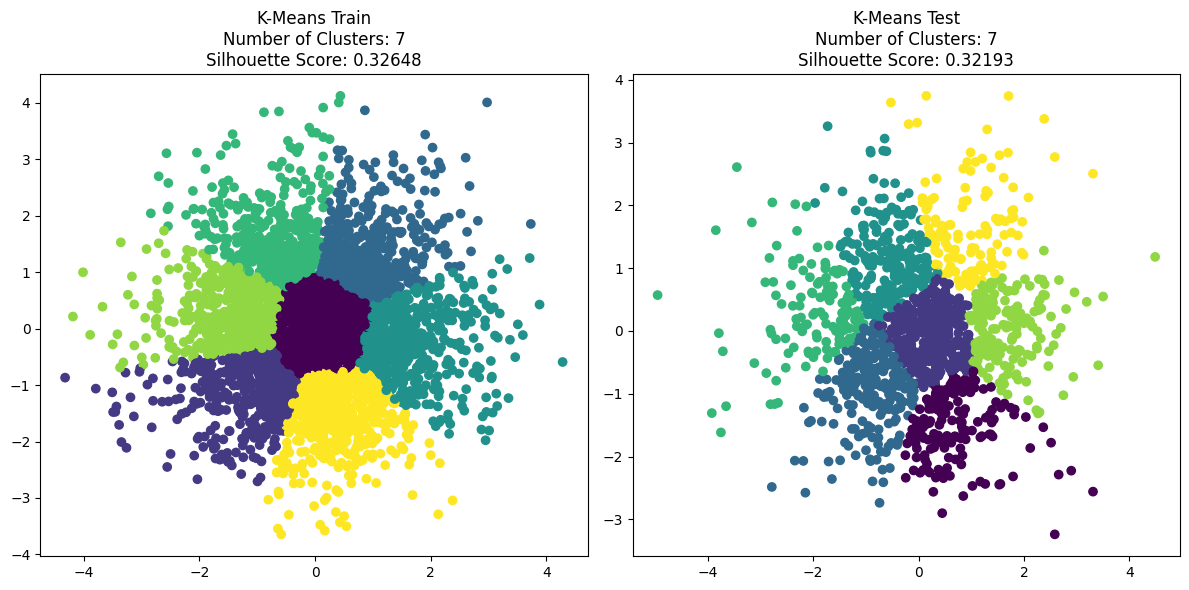

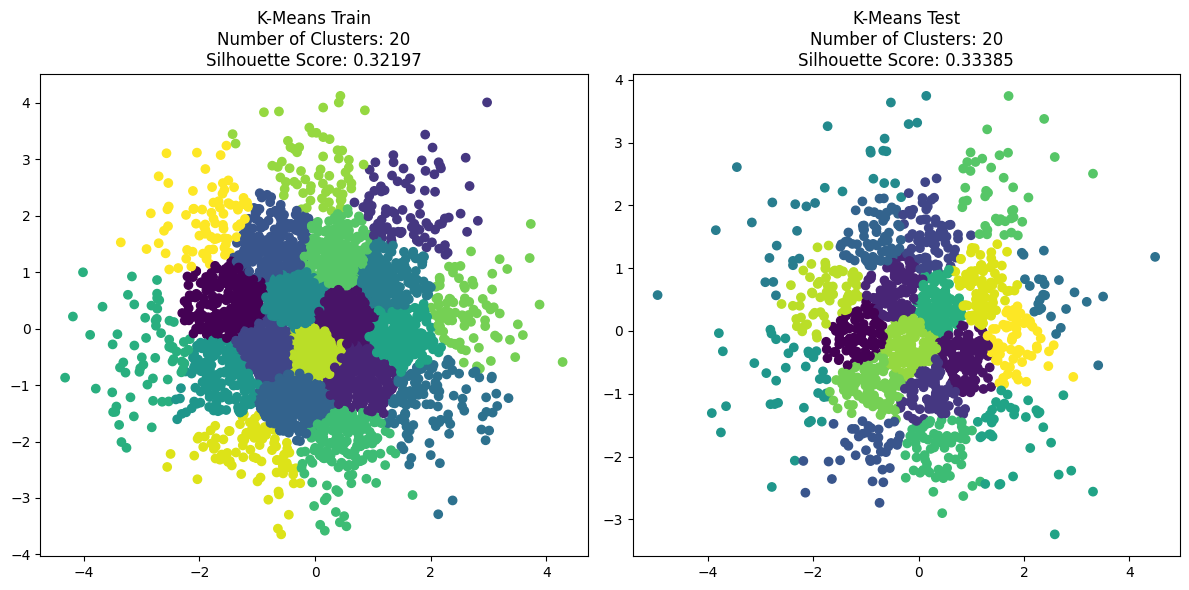

In [34]:
for n_clusters in clusters:
    kMeans = KMeans(n_clusters=n_clusters, init='k-means++', algorithm='elkan', max_iter=100)
    kMeans.fit(X_train_lda)
    # print('Number of clusters = ', n_clusters)
    evaluate_clustering(kMeans, number_of_clusters=n_clusters, model_name="K-Means")
    plt.show()

## Agglomerative

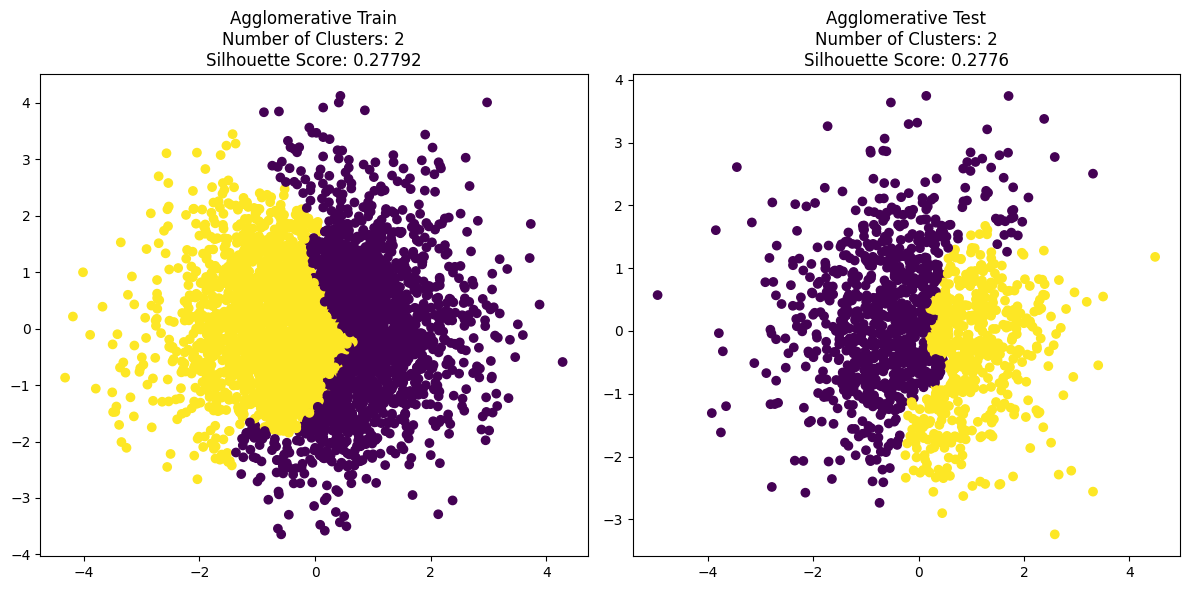

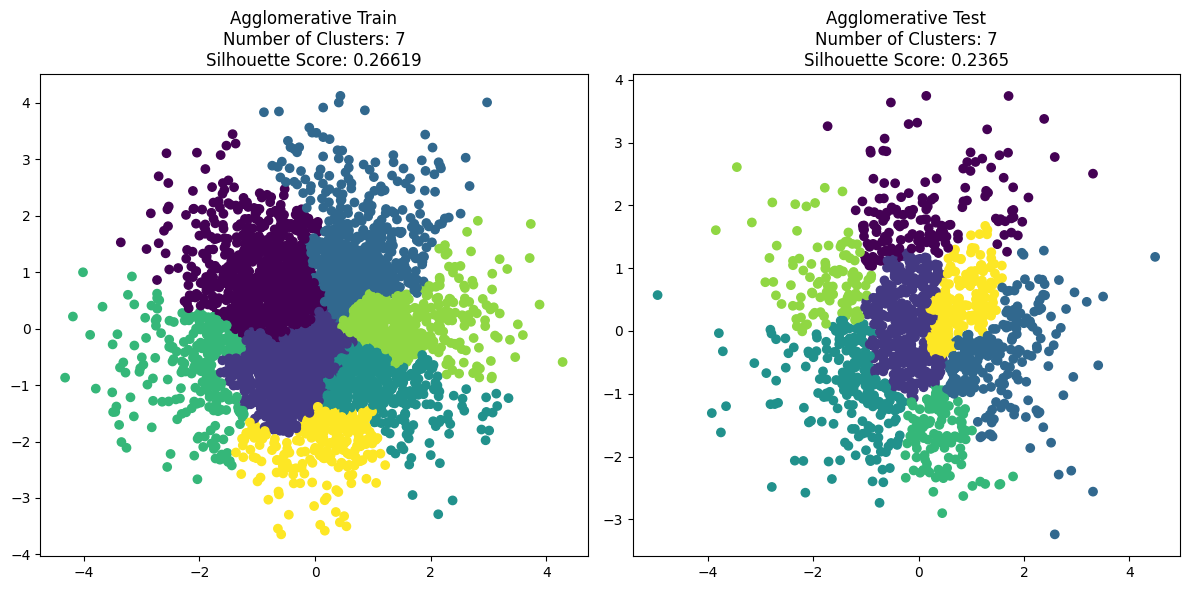

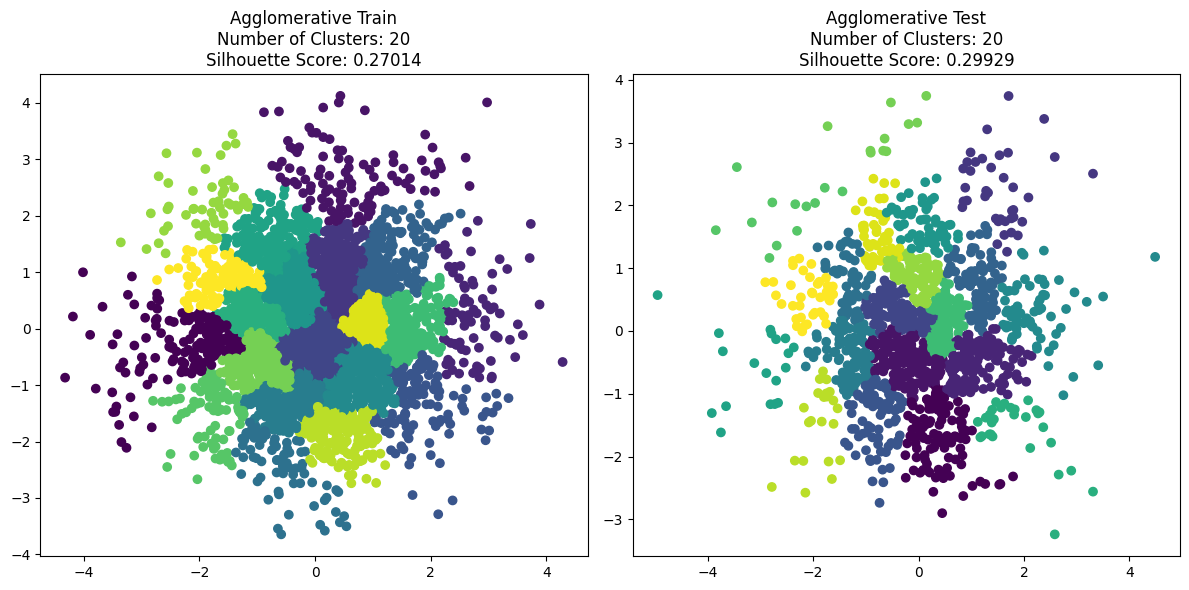

In [35]:
for n_clusters in clusters:
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    agglomerative.fit(X_train_lda)
    # print('Number of clusters = ', n_clusters)
    evaluate_clustering(agglomerative, number_of_clusters=n_clusters, model_name="Agglomerative")
    plt.show()

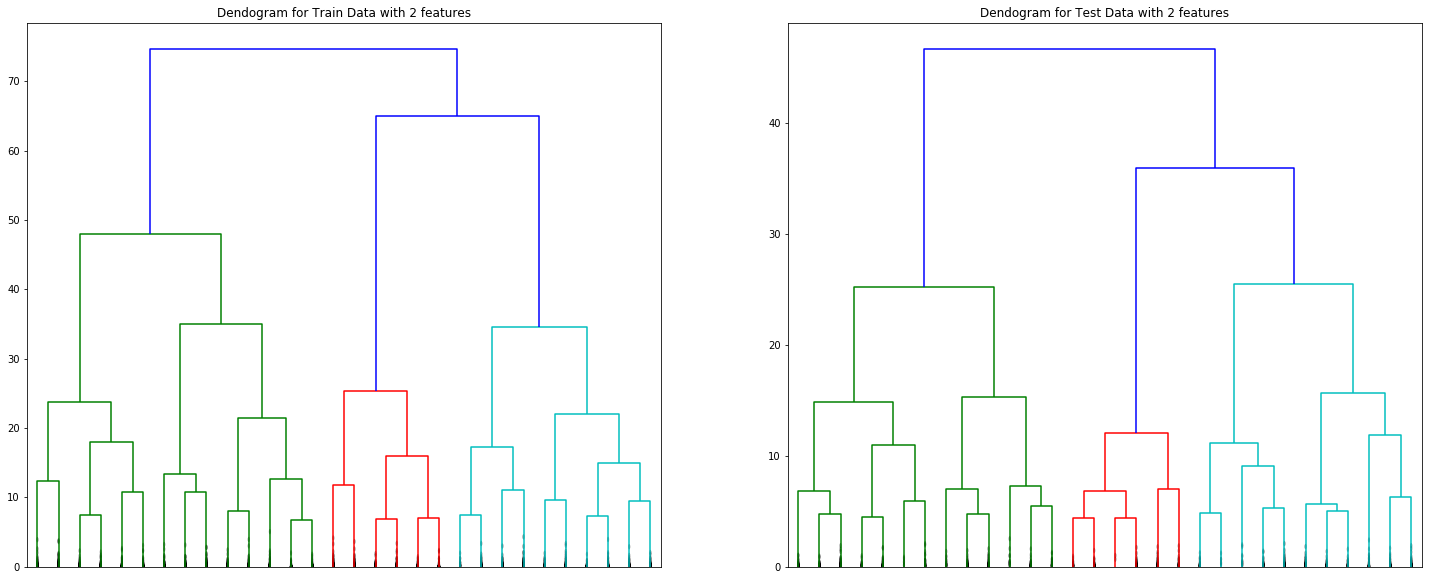

In [25]:
plot_dendrogram( X_train_lda,X_test_lda,num_of_features=2)

# Clustring Using Data with 3 Features

In [36]:
dr = DimensionReduction(X_train, y_train, X_test, y_test)
X_train_lda, X_test_lda = dr.LDA(n_components=3)

## K-Means

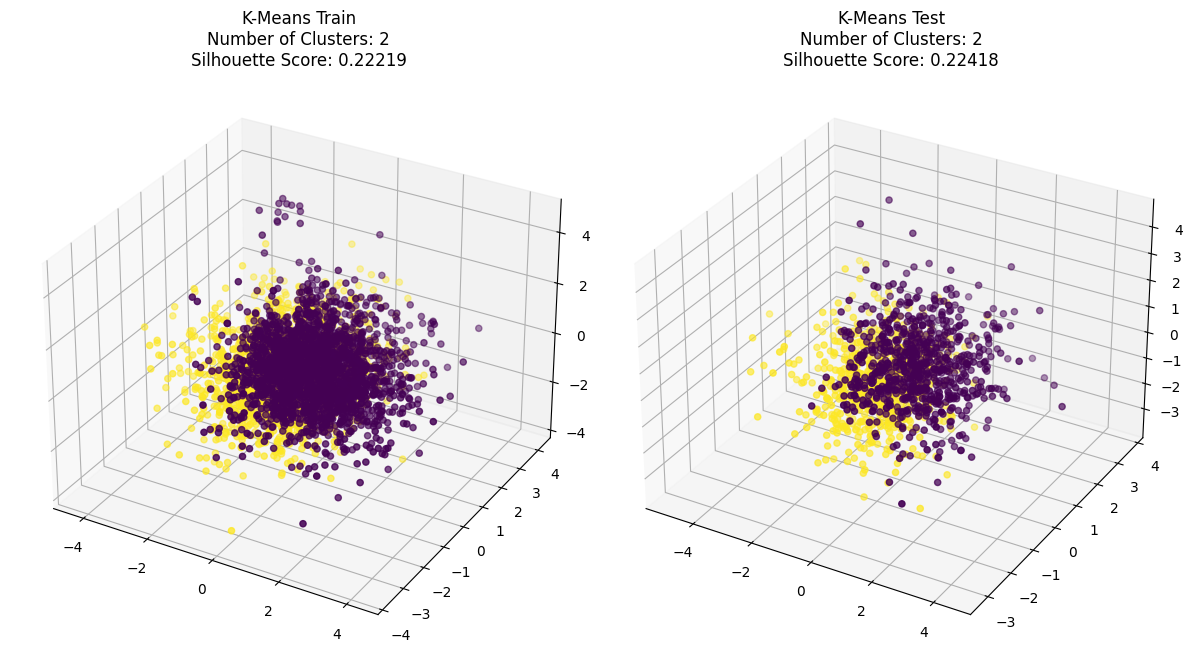

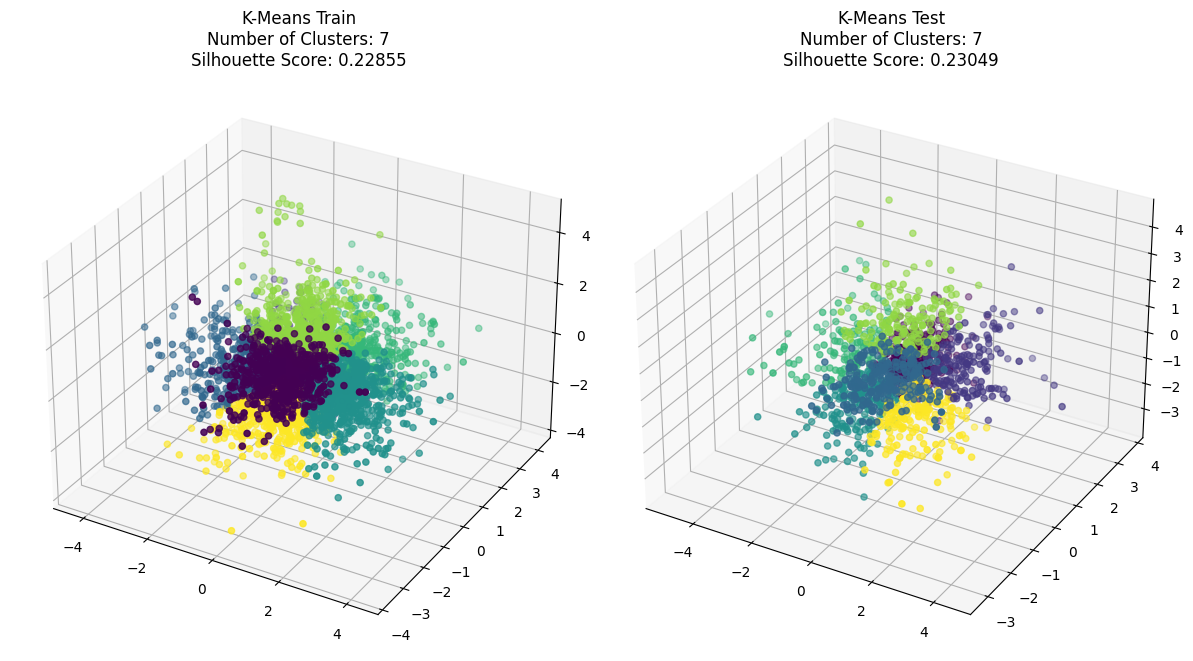

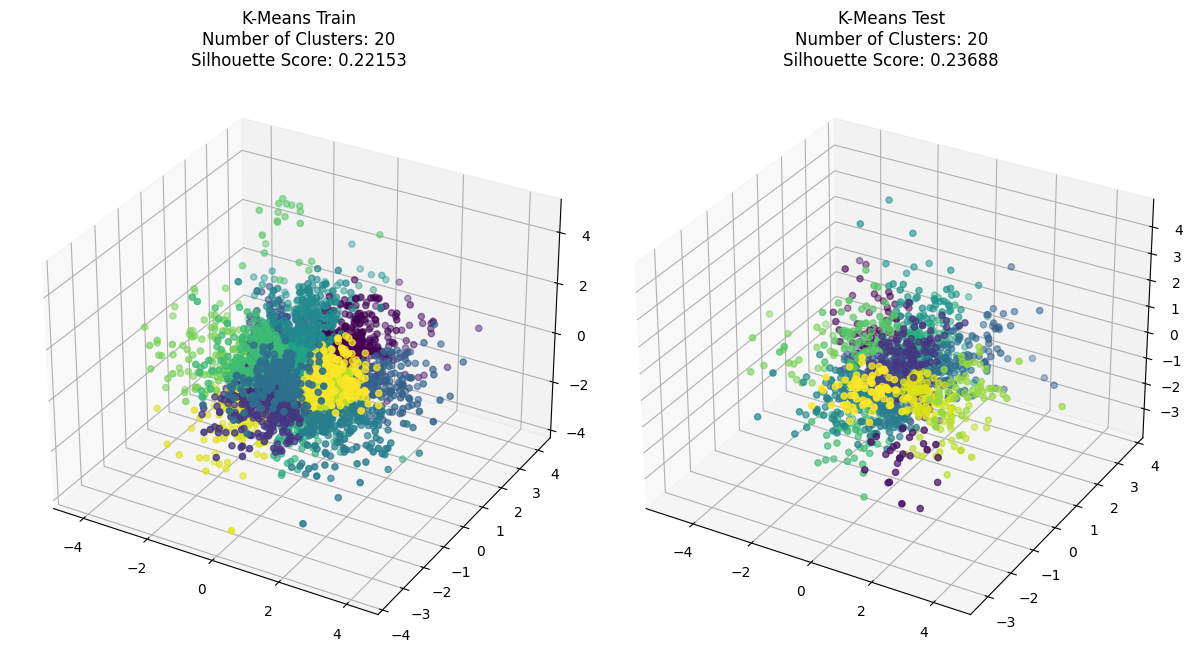

In [37]:
for n_clusters in clusters:
    kMeans = KMeans(n_clusters=n_clusters, init='k-means++', algorithm='elkan', max_iter=100)
    kMeans.fit(X_train_lda)
    # print('Number of clusters = ', n_clusters)
    evaluate_clustering(kMeans, number_of_clusters=n_clusters, model_name="K-Means", d=3)
    plt.show()

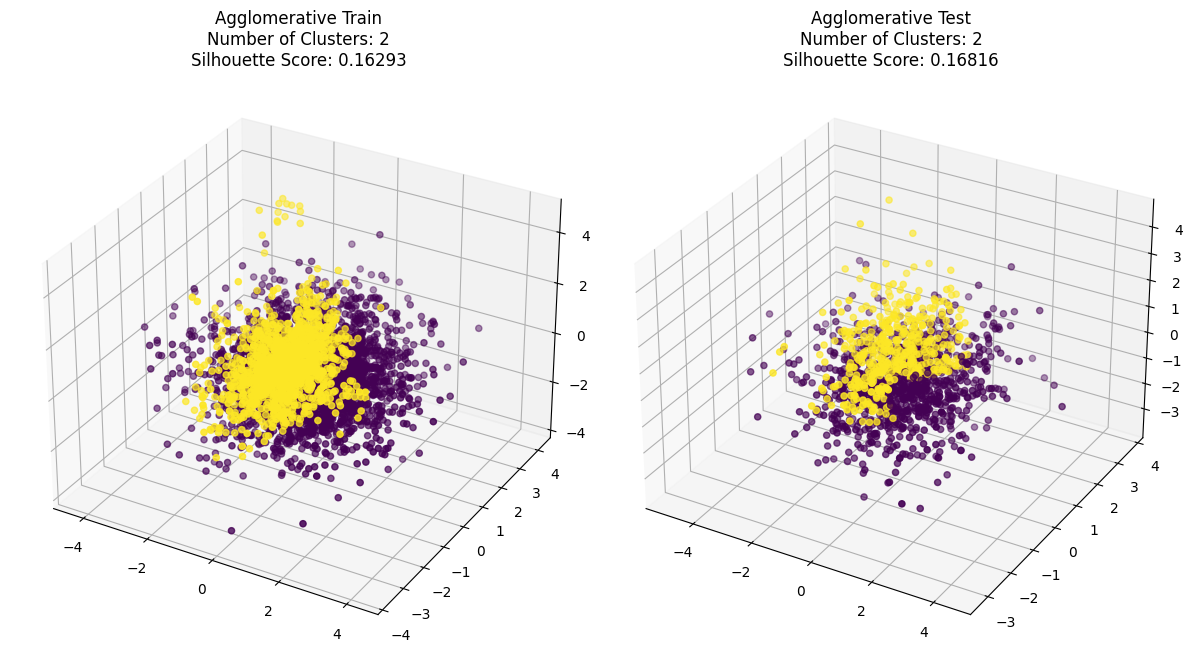

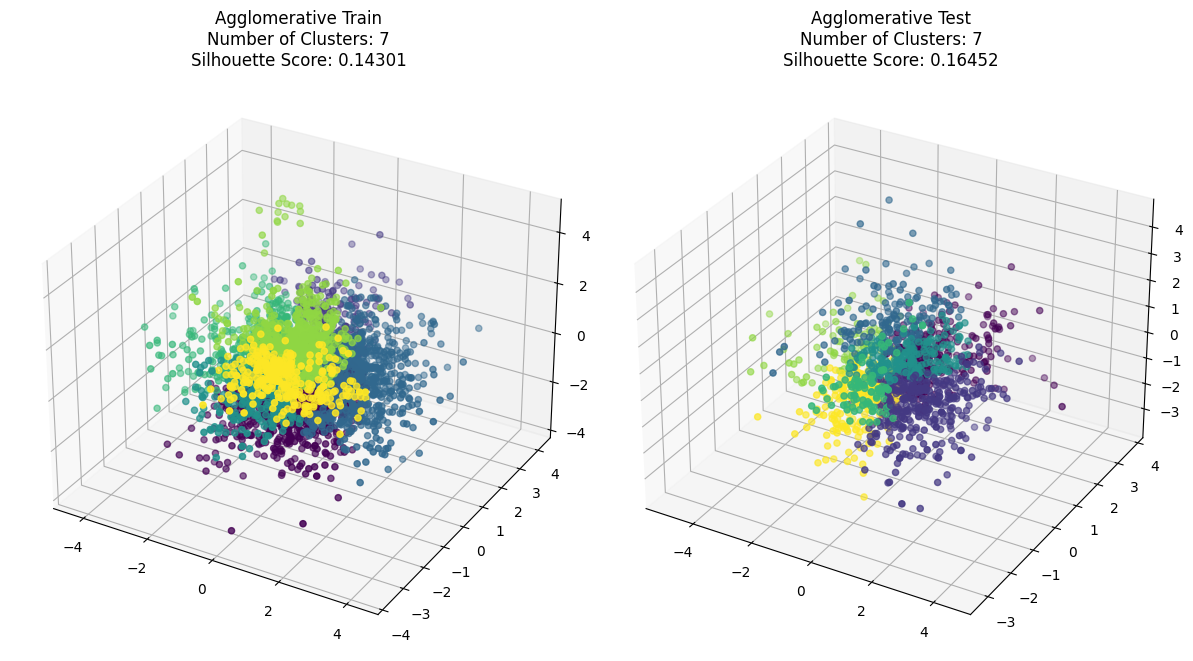

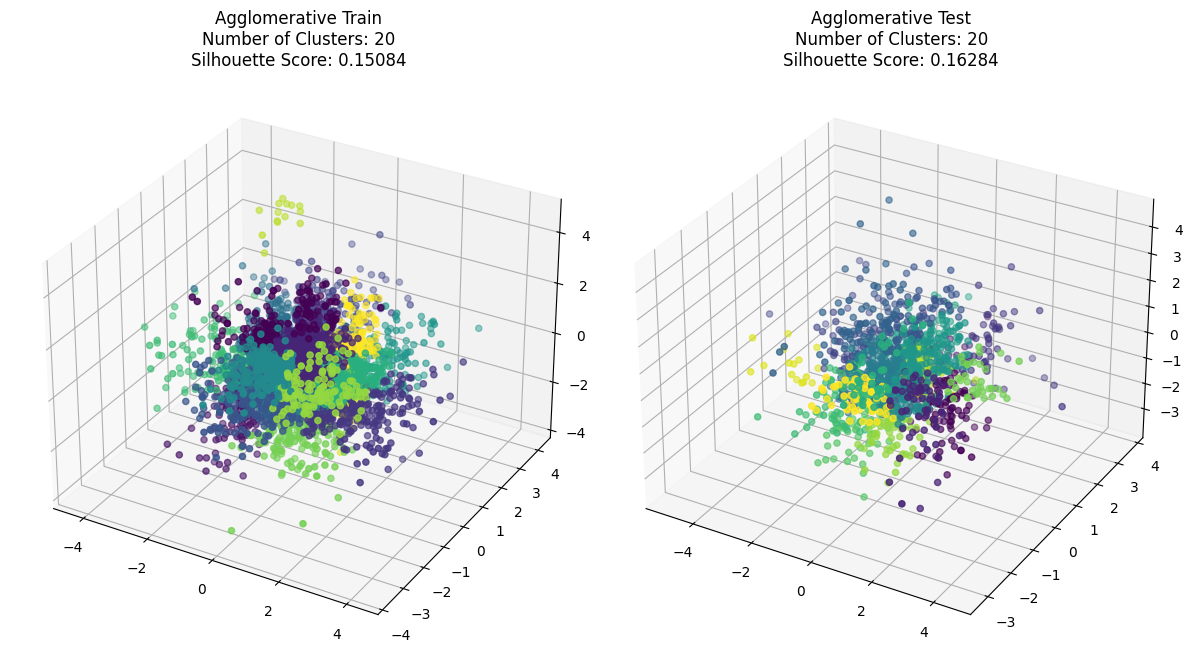

In [38]:
for n_clusters in clusters:
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    agglomerative.fit(X_train_lda)
    # print('Number of clusters = ', n_clusters)
    evaluate_clustering(agglomerative, number_of_clusters=n_clusters, model_name="Agglomerative", d=3)
    plt.show()

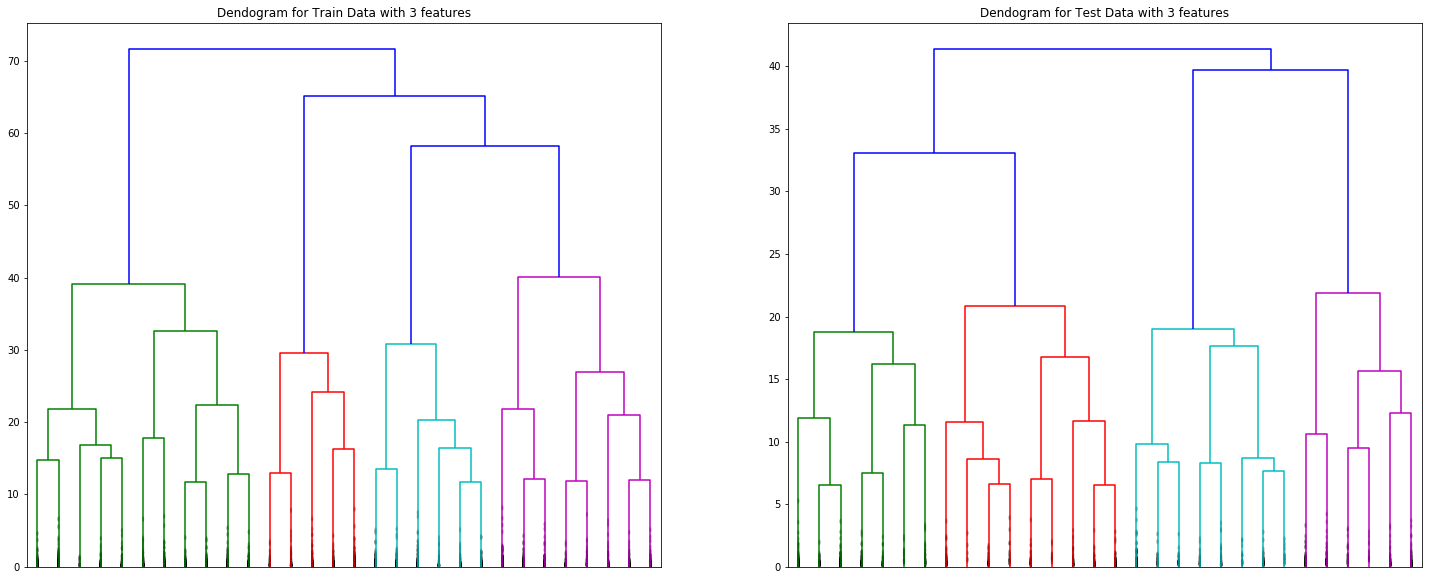

In [28]:
plot_dendrogram( X_train_lda,X_test_lda,num_of_features=3)